<a href="https://colab.research.google.com/github/rahmansadiqgit/Thesis_Work/blob/master/Fishing_Url_Dectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading XGBoost


In [1]:
import kagglehub
path = kagglehub.dataset_download("hasibur013/phishing-data")

Using Colab cache for faster access to the 'phishing-data' dataset.


In [2]:
!ls $path

PhishingData.csv


In [3]:
path

'/kaggle/input/phishing-data'

In [4]:
import pandas as pd
xgdf = pd.read_csv(path+"/PhishingData.csv")

In [5]:
xgdf.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


# 1) url_features extraction

In [6]:
# url_features.py
import re
import socket
from urllib.parse import urlparse

def extract_url_features(url):
    parsed = urlparse(url)
    hostname = parsed.hostname if parsed.hostname else ""

    features = {}


    # 1. IP Address Check
    try:
        socket.inet_aton(hostname)
        features["having_IPhaving_IP_Address"] = 1
    except:
        features["having_IPhaving_IP_Address"] = -1

    # 2. URL Length
    features["URLURL_Length"] = 1 if len(url) < 54 else -1

    # 3. Shortening Service
    shorteners = r"(bit\.ly|goo\.gl|tinyurl|shorte\.st|is\.gd|buff\.ly|adf\.ly)"
    features["Shortining_Service"] = -1 if re.search(shorteners, url) else 1

    # 4. @ Symbol
    features["having_At_Symbol"] = -1 if "@" in url else 1

    # 5. Extra //
    features["double_slash_redirecting"] = -1 if "//" in url[7:] else 1

    # 6. Prefix/Suffix
    features["Prefix_Suffix"] = -1 if "-" in hostname else 1

    # 7. Subdomain
    features["having_Sub_Domain"] = -1 if hostname.count(".") >= 3 else 1

    # 8. SSLfinal_State (URL only version)
    features["SSLfinal_State"] = 1 if url.startswith("https") else -1

    # 9. HTTPS Token inside domain
    features["HTTPS_token"] = -1 if "https" in hostname else 1

    return features


# html_features extraction

In [7]:
# html_features.py
import re
import requests
from bs4 import BeautifulSoup

def safe_request(url):
    try:
        r = requests.get(url, timeout=5, headers={'User-Agent': 'Mozilla/5.0'})
        if r.status_code == 200:
            return r.text
    except:
        pass
    return None

def extract_html_features(url, domain):
    html = safe_request(url)
    features = {}

    if html is None:
        # HTML-dependent features default to -1
        html_features = [
            "Favicon", "port", "Request_URL", "URL_of_Anchor",
            "Links_in_tags", "SFH", "Submitting_to_email",
            "Abnormal_URL", "Redirect", "on_mouseover",
            "RightClick", "popUpWidnow", "Iframe", "DNSRecord"
        ]
        for f in html_features:
            features[f] = -1
        return features

    soup = BeautifulSoup(html, "lxml")
    features["DNSRecord"] = 1

    # Favicon
    features["Favicon"] = 1 if soup.find("link", rel=lambda x: x and "icon" in x.lower()) else -1

    # External images (Request_URL)
    images = soup.find_all("img")
    if images:
        external = sum(1 for i in images if i.get("src") and domain not in i.get("src"))
        features["Request_URL"] = -1 if external / len(images) > 0.5 else 1
    else:
        features["Request_URL"] = 1

    # Anchor tags
    anchors = soup.find_all("a")
    if anchors:
        suspicious = sum(1 for a in anchors if a.get("href") in ["", "#"] or "javascript" in str(a.get("href")))
        features["URL_of_Anchor"] = -1 if suspicious / len(anchors) > 0.5 else 1
    else:
        features["URL_of_Anchor"] = 1

    # Meta/script/link external
    tags = soup.find_all(["meta", "script", "link"])
    if tags:
        suspicious = sum(1 for t in tags if (t.get("src") and domain not in t.get("src")) or (t.get("href") and domain not in t.get("href")))
        features["Links_in_tags"] = -1 if suspicious / len(tags) > 0.5 else 1
    else:
        features["Links_in_tags"] = 1

    # SFH
    forms = soup.find_all("form")
    sfh_flag = 1
    for f in forms:
        action = f.get("action", "")
        if action == "" or "about:blank" in action:
            sfh_flag = -1
            break
    features["SFH"] = sfh_flag

    # Email submission
    features["Submitting_to_email"] = -1 if "mailto:" in html else 1

    # Abnormal URL
    features["Abnormal_URL"] = -1 if domain not in html else 1

    # Redirects
    features["Redirect"] = -1 if len(re.findall(r"window\.location", html)) > 2 else 1

    # Mouseover script
    features["on_mouseover"] = -1 if "onmouseover=" in html else 1

    # Right-click block
    features["RightClick"] = -1 if "event.button==2" in html else 1

    # Popup
    features["popUpWidnow"] = -1 if "alert(" in html else 1

    # Iframe
    features["Iframe"] = -1 if soup.find("iframe") else 1

    # Port (simplified)
    features["port"] = 1

    return features


In [8]:
from urllib.parse import urlparse
from collections import OrderedDict

def extract_features(url):
    parsed = urlparse(url)
    domain = parsed.hostname or ""

    data = OrderedDict()  # ensures consistent order

    # Make sure these functions exist and return dictionaries
    data.update(extract_url_features(url))
    # data.update(extract_whois_features(domain))
    data.update(extract_html_features(url, domain))

    return data


In [9]:

FEATURE_LIST = list(extract_features("www.facebook.com").keys())


# Training

In [10]:
xgdf.columns = xgdf.columns.str.strip()


In [11]:
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split

X = xgdf[FEATURE_LIST]
y = xgdf['Result'].replace(-1, 0)
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )


# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'binary:logistic',
    'max_depth': 7,
    'eta': 0.07,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'eval_metric': 'logloss'
}

evals = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    callbacks=[EarlyStopping(rounds=50, save_best=True)],
    verbose_eval=False
)


#Evalution Function

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
import matplotlib.pyplot as plt

def xgboost2_Evaluation(urls, y_test,plot=True):
    # Extract features for each URL
    records = [extract_features(url) for url in urls]
    X_test = pd.DataFrame(records, columns=FEATURE_LIST)

    # Convert to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Predict using xgboost model
    pred_y = bst.predict(dtest)

    # Convert probability to class (0/1)
    pred_y = (pred_y >= 0.5).astype(int)
    y_pred = pd.Series(pred_y)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)




    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Phishing', 'Legitimate']))

    # Plot confusion matrix
    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[ 'Phishing' ,'Legitimate' ],
                    yticklabels=[ 'Phishing' , 'Legitimate'],
                    cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('Actual Label', fontsize=12)
        plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%} | F1-Score: {f1:.4f}',
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()




#Model Predict

In [13]:
def xgboost_predict(urls):
     # Extract features for each URL
    records = [extract_features(url) for url in urls]
    X_test = pd.DataFrame(records, columns=FEATURE_LIST)

    # Convert to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Predict using xgboost model
    pred_y = bst.predict(dtest)
    return pred_y

# Loading Neural Network


In [14]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [15]:
class URLPreprocessor:
    """Handles URL encoding and vocabulary creation"""


    def __init__(self, max_len=200):
        self.max_len = max_len
        self.char_to_idx = None
        self.vocab_size = None


    def fit(self, urls):
        """Build character vocabulary from URLs"""
        # Collect unique characters
        chars = set()
        for url in urls:
            chars.update(str(url).lower())

        # Add special URL characters
        special_chars = ['/', '.', '-', '_', '=', '?', '&', '%', ':', '@', '+', '~', '#']
        chars.update(special_chars)

        # Create mapping: 0=padding, 1=unknown
        self.char_to_idx = {char: idx+2 for idx, char in enumerate(sorted(chars))}
        self.char_to_idx['<PAD>'] = 0
        self.char_to_idx['<UNK>'] = 1
        self.vocab_size = len(self.char_to_idx)

        print(f"Vocabulary size: {self.vocab_size}")
        return self

    def encode_url(self, url):
        """Encode a single URL to integer sequence"""
        url = str(url).lower()
        encoded = [self.char_to_idx.get(c, 1) for c in url][:self.max_len]

        # Pad if necessary
        if len(encoded) < self.max_len:
            encoded += [0] * (self.max_len - len(encoded))

        return np.array(encoded)


    def transform(self, urls):
        """Encode multiple URLs"""
        return np.array([self.encode_url(url) for url in urls])


    def fit_transform(self, urls):
        """Fit and transform in one step"""
        self.fit(urls)
        return self.transform(urls)


In [16]:
def load_and_prepare_data(df, test_size=0.2, random_state=42):
    """Load data and split into train/validation sets"""

    # Initialize preprocessor
    preprocessor = URLPreprocessor(max_len=200)



    # Encode URLs
    X = preprocessor.fit_transform(df['URL'])
    y = df['label'].values


    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_val, y_train, y_val, preprocessor

In [17]:
def create_phishing_detector(vocab_size, max_len=200):
    """
    Simplified CNN architecture for URL classification
    - Smaller, faster, more efficient
    - Better regularization to prevent overfitting
    """

    model = Sequential([
        # Character embedding
        Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),

        # First convolutional block
        Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),

        # Second convolutional block
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),

        # Global pooling
        GlobalMaxPooling1D(),

        # Dense layers
        Dense(64, activation='relu'),
        Dropout(0.4),

        Dense(32, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile with optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [84]:
# ============================================================================
# 3. TRAINING
# ============================================================================

def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64):
    """Train the model with callbacks"""

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )


In [42]:
# ============================================================================
# 4. EVALUATION
# ============================================================================

def evaluate_model(model, X_test, y_test, plot=True):
    """Comprehensive model evaluation"""

    # Predictions
    y_pred_probs = model.predict(X_test, verbose=0).flatten()

    y_pred = (y_pred_probs > 0.5).astype(int)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)




    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Phishing', 'Legitimate']))

    # Plot confusion matrix
    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[ 'Phishing' ,'Legitimate' ],
                    yticklabels=[ 'Phishing' , 'Legitimate'],
                    cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('Actual Label', fontsize=12)
        plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%} | F1-Score: {f1:.4f}',
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


In [20]:
def plot_training_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [21]:
# ============================================================================
# 5. MAIN PIPELINE
# ============================================================================

def main(df):
    """Complete training and evaluation pipeline"""

    print("Starting Phishing URL Detection Pipeline...")
    print("="*60)

    # Step 1: Prepare data
    print("\n[1/4] Preparing data...")
    X_train, X_val, y_train, y_val, preprocessor = load_and_prepare_data(df)


    # Step 2: Create model
    print("\n[2/4] Creating model...")
    model = create_phishing_detector(preprocessor.vocab_size)

    model.summary()

    # Step 3: Train model
    print("\n[3/4] Training model...")
    history = train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=64)

    # Step 4: Evaluate model
    print("\n[4/4] Evaluating model...")
    results = evaluate_model(model, X_val, y_val, plot=True)

    # Plot training history
    plot_training_history(history)

    print("\n✓ Pipeline completed successfully!")

    return model, preprocessor, history, results

# Additional Method

In [43]:
def Neural_Network_Evaluation(urls , labels):
  urls = preprocessor.transform(urls)
  evaluate_model(model, urls ,labels, plot=True)


In [ ]:
def Neural_Network_Predict(urls):
  urls = preprocessor.transform(urls)
  return model.predict(urls)

In [48]:

def Fishing_Url_Predict(urls):
    pred1 = np.array(xgboost_predict(urls)).flatten()
    pred2 = np.array(Neural_Network_Predict(urls)).flatten()

    if len(pred1) != len(pred2):
        raise ValueError("Prediction lists must have the same length!")

    avg_predictions = (pred1 + pred2) / 2.0

    return avg_predictions  # now returns a NumPy array


In [ ]:
def Fishing_Url_Evaluation(urls , y_test , plot=True):
    y_pred = Fishing_Url_Predict(urls)
    y_pred = (y_pred >= 0.5).astype(int)
     # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Phishing', 'Legitimate']))

    # Plot confusion matrix
    if plot:
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[ 'Phishing' ,'Legitimate' ],
                    yticklabels=[ 'Phishing' , 'Legitimate'],
                    cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('Actual Label', fontsize=12)
        plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2%} | F1-Score: {f1:.4f}',
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


# Actual Training Neural Network

In [22]:
import kagglehub
path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")

Using Colab cache for faster access to the 'web-page-phishing-detection-dataset' dataset.


In [23]:
!ls $path

dataset_phishing.csv


In [24]:
import pandas as pd

df = pd.read_csv(path + "/dataset_phishing.csv")

In [25]:
df = df.rename(columns={"status": "label" , "url" : "URL"})
df["label"] = df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-1066409383.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace({


In [89]:
df[['URL' , 'url']].head()

,URL,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,label
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,0
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


In [ ]:

model , preprocessor , history , results = main(df)


Starting Phishing URL Detection Pipeline...

[1/4] Preparing data...
Vocabulary size: 76
Dataset shape: X=(11430, 200), y=(11430,)

Training set: (9144, 200)
Validation set: (2286, 200)

[2/4] Creating model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


[3/4] Training model...
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.5820 - loss: 1.2086 - precision: 0.5747 - recall: 0.5324 - val_accuracy: 0.6807 - val_loss: 0.6831 - val_precision: 0.6233 - val_recall: 0.9134 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accuracy: 0.7387 - loss: 0.5257 - precision: 0.7357 - recall: 0.7528 - val_accuracy: 0.5617 - val_loss: 0.6568 - val_precision: 0.9796 - val_recall: 0.1260 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.8136 - loss: 0.4247 - precision: 0.8039 - recall: 0.8246 - val_accuracy: 0.8381 - val_loss: 0.5362 - val_precision: 0.8908 - val_recall: 0.7708 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.8392 - loss: 0.3814 - precision: 0.8261 - recall: 0.8622 - val_accuracy: 0.8185 - val_loss: 0.4285 - val_precision: 0.7450 - val_recall: 0.9685 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━

# It's time to test

# Checking by Claude 5000 urls

In [60]:
from google.colab import files

uploaded = files.upload()

Saving phishing_url_dataset_5000.csv to phishing_url_dataset_5000.csv


In [61]:
!ls

Neural_Network.ipynb	       sample_data	     xgboost.ipynb
phishing_url_dataset_5000.csv  url_dataset_5000.csv


In [62]:
Claude_df = pd.read_csv("phishing_url_dataset_5000.csv")

In [63]:
Claude_df.head()

,url,label
0,http://slzck.com/login,phishing
1,http://13.206.250.163/verify-account,phishing
2,http://pinterest.c0m/login,phishing
3,http://inte1.c0m/login,phishing
4,http://login1550.download/update,phishing


In [64]:
Claude_df["label"] = Claude_df["label"].replace({
    "legitimate": 1,
    "phishing": 0
}).astype(int)

/tmp/ipython-input-2564128249.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Claude_df["label"] = Claude_df["label"].replace({


In [65]:
Claude_shuffled = Claude_df.sample(frac=1, random_state=2).reset_index(drop=True)


In [90]:
Claude_shuffled.head()

,url,label
0,http://api.netflix.com/login,1
1,https://beta.spotify.com/profile,1
2,http://account-linkedin-com.ga/login,0
3,http://cnn.czm/news,0
4,http://135.160.90.216/verify-account,0


## XG


Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.93      0.96      0.95       505
  Legitimate       0.96      0.93      0.94       495

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



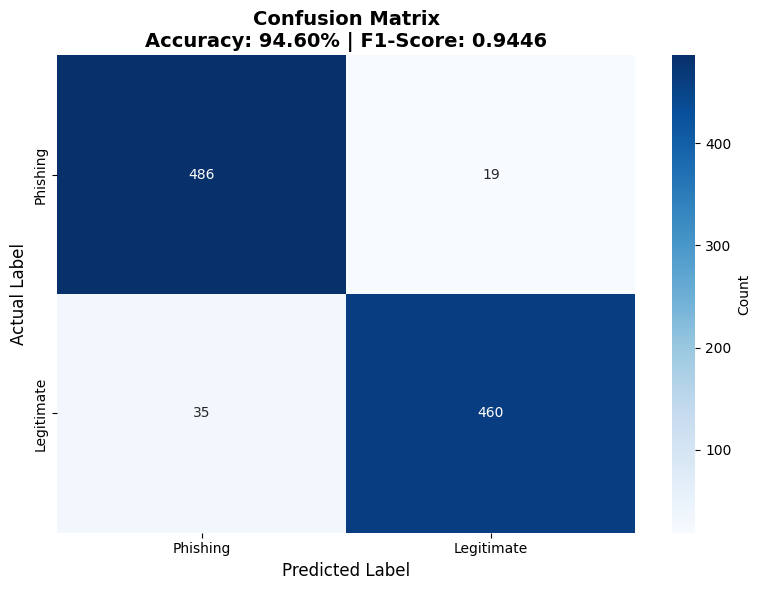

In [68]:
xgboost2_Evaluation(Claude_shuffled.url.head(1000) , Claude_shuffled.label.head(1000))

## Neural


Confusion Matrix:
[[2219  281]
 [ 763 1737]]

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.74      0.89      0.81      2500
  Legitimate       0.86      0.69      0.77      2500

    accuracy                           0.79      5000
   macro avg       0.80      0.79      0.79      5000
weighted avg       0.80      0.79      0.79      5000



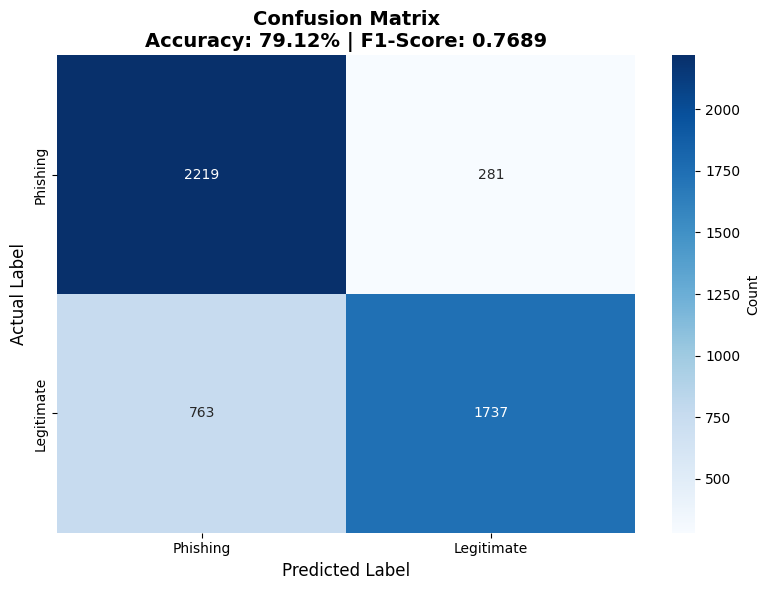

In [69]:
Neural_Network_Evaluation(Claude_shuffled.url , Claude_shuffled.label)

## Combine

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Confusion Matrix:
[[2379  121]
 [ 361 2139]]

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.87      0.95      0.91      2500
  Legitimate       0.95      0.86      0.90      2500

    accuracy                           0.90      5000
   macro avg       0.91      0.90      0.90      5000
weighted avg       0.91      0.90      0.90      5000



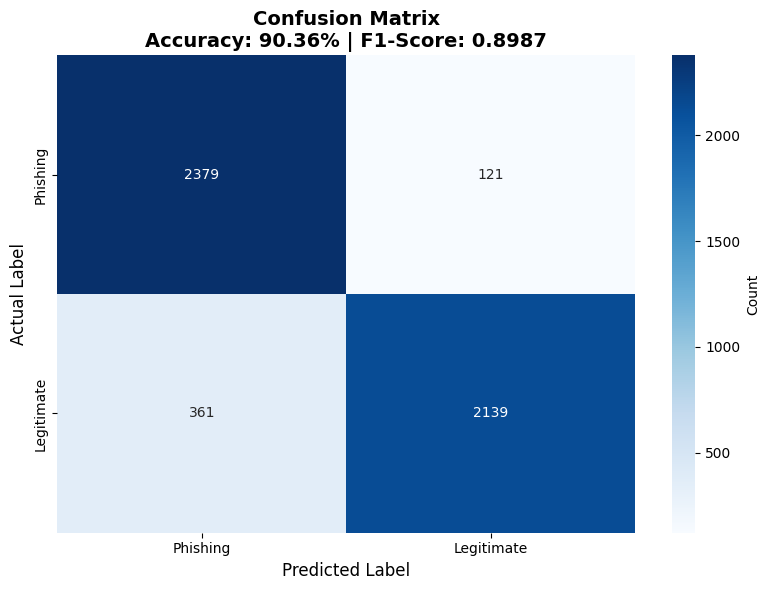

In [70]:
Fishing_Url_Evaluation(Claude_shuffled.url , Claude_shuffled.label)

# Testing by XGBoost1 DataSet

In [71]:

path = kagglehub.dataset_download("saqibgulzarbhat/uci-phishing-detection-dataset")

Using Colab cache for faster access to the 'uci-phishing-detection-dataset' dataset.


In [72]:

XG1_df = pd.read_csv(path+'/PhiUSIIL_Phishing_URL_Dataset.csv')

In [95]:
XG1_df.shape

(235795, 56)

## XG




/tmp/ipython-input-2681465185.py:31: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(html, "lxml")



Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.97      0.65      0.78       173
  Legitimate       0.84      0.99      0.91       327

    accuracy                           0.87       500
   macro avg       0.90      0.82      0.84       500
weighted avg       0.89      0.87      0.86       500



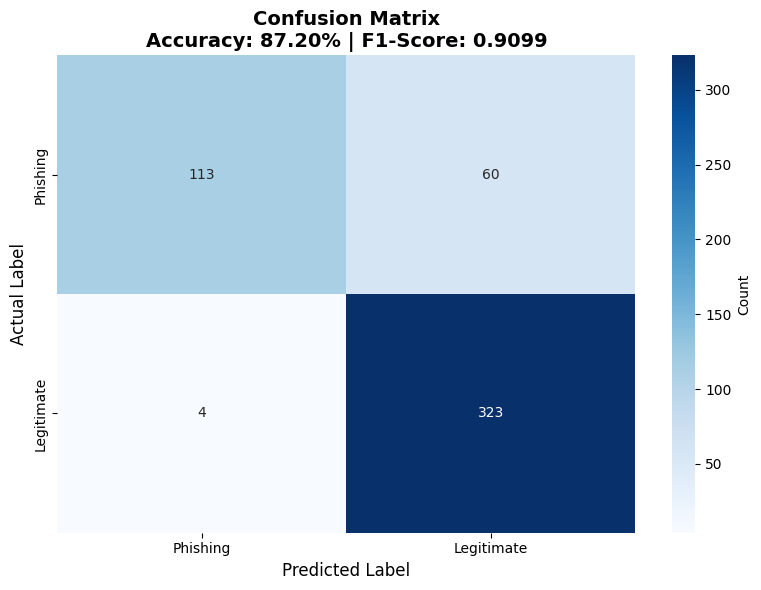

In [73]:
xgboost2_Evaluation(XG1_df.URL.head(500) , XG1_df.label.head(500))

## Neural


Confusion Matrix:
[[ 83  90]
 [  1 326]]

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.99      0.48      0.65       173
  Legitimate       0.78      1.00      0.88       327

    accuracy                           0.82       500
   macro avg       0.89      0.74      0.76       500
weighted avg       0.85      0.82      0.80       500



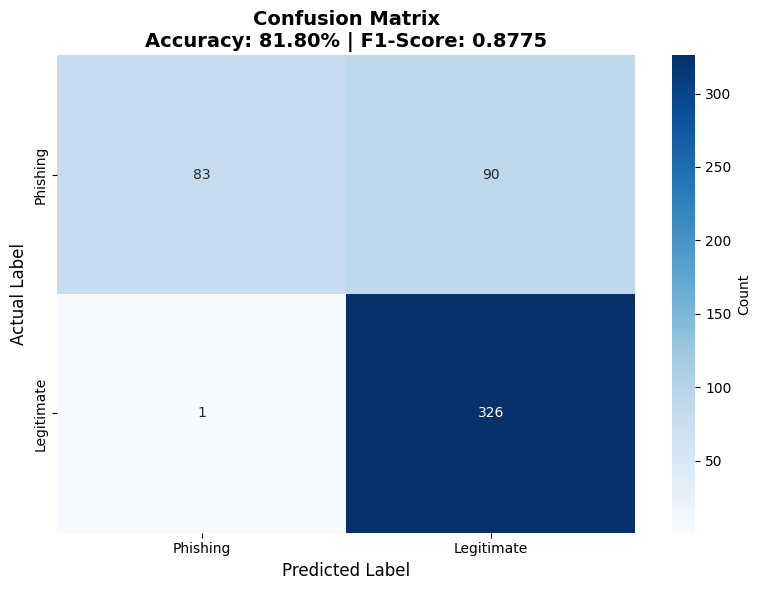

In [75]:
Neural_Network_Evaluation(XG1_df.URL.head(500) , XG1_df.label.head(500))

## Combine

/tmp/ipython-input-2681465185.py:31: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(html, "lxml")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Confusion Matrix:
[[131  42]
 [  1 326]]

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.99      0.76      0.86       173
  Legitimate       0.89      1.00      0.94       327

    accuracy                           0.91       500
   macro avg       0.94      0.88      0.90       500
weighted avg       0.92      0.91      0.91       500



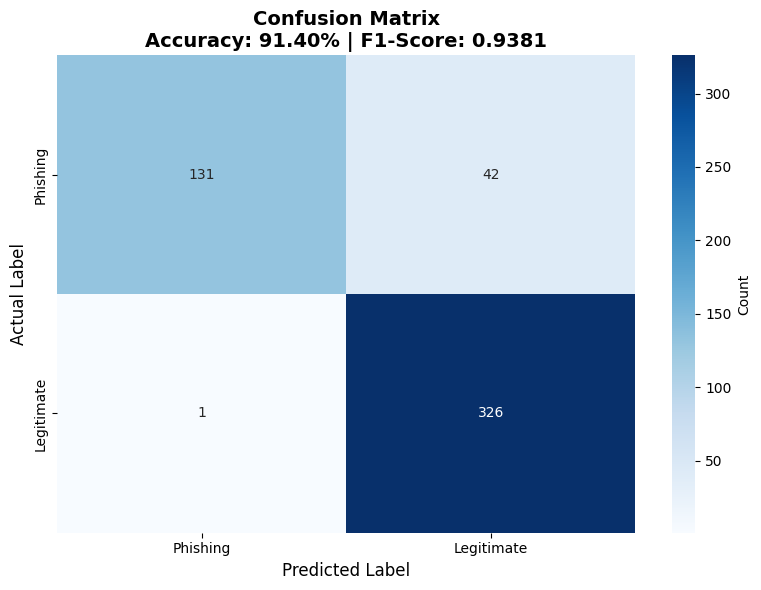

In [83]:
Fishing_Url_Evaluation(XG1_df.URL.head(500) , XG1_df.label.head(500))